(forecasting_with_ar)=
# Forecasting with Structural AR Timeseries

:::{post} Oct 20, 2022
:tags: forecasting, autoregressive, bayesian structural timeseries
:category: intermediate
:author: Nathaniel Forde
:::

Bayesian structural timeseries models are an interesting way to learn about the structure inherent in any observed timeseries data. It also gives us the ability to project forward the implied predictive distribution granting us another view on forecasting problems. We can treat the learned characteristics of the timeseries data observed to-date as informative about the structure of the unrealised future state of the same measure. 

In this notebook we'll see how to fit and predict a range of auto-regressive structural timeseries models and, importantly, how to predict future observations of the models.

In [1]:
import aesara as at
import arviz as az
import numpy as np
import pandas as pd
import pymc as pm

from matplotlib import pyplot as plt

In [2]:
RANDOM_SEED = 8929
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

## Generate Fake Autoregressive Data

First we will generate a simple autoregressive timeseries. We will show how to specify a model to fit this data and then add a number of complexities to the data and show how they too can be captured with an autoregressive model and used to predict the shape of the future.

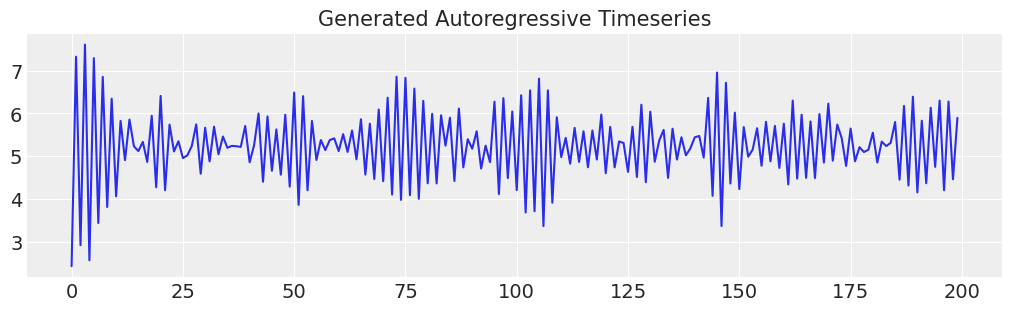

In [3]:
def simulate_ar(intercept, coef1, coef2, noise=0.3, *, warmup=10, steps=200):
    # We sample some extra warmup steps, to let the AR process stabilize
    draws = np.zeros(warmup + steps)
    # Initialize first draws at intercept
    draws[:2] = intercept
    for step in range(2, warmup + steps):
        draws[step] = (
            intercept
            + coef1 * draws[step - 1]
            + coef2 * draws[step - 2]
            + np.random.normal(0, noise)
        )
    # Discard the warmup draws
    return draws[warmup:]


ar1_data = simulate_ar(10, -0.9, 0)

fig, ax = plt.subplots(figsize=(10, 3))
ax.set_title("Generated Autoregressive Timeseries", fontsize=15)
ax.plot(ar1_data);

## Specifying the Model

We'll walk through the model step by step and then generalise the pattern into a function that can be used to take increasingly complex structural combinations of components.

In [4]:
## Set up a dictionary for the specification of our priors
## We set up the dictionary to specify size of the AR coefficients in
## case we want to vary the AR lags.
priors = {
    "coef_0": {"mu": 10, "sigma": 0.1, "size": 2},
    "coef_1": {"mu": 0.2, "sigma": 0.1, "size": 2},
    "sigma": 8,
    "init": {"mu": 9, "sigma": 0.1, "size": 1},
}

## Initialise the model
with pm.Model() as AR:
    pass

## Define the time interval for fitting the data
t_data = list(range(len(ar1_data)))
## Add the time interval as a mutable coordinate to the model to allow for future predictions
AR.add_coord("obs_id", t_data, mutable=True)

with AR:
    ## Data containers to enable prediction
    t = pm.MutableData("t", t_data, dims="obs_id")
    y = pm.MutableData("y", ar1_data, dims="obs_id")

    # The first coefficient will be the constant term but we need to set priors for each coefficient in the AR process
    coefs_0 = pm.Normal("coef_0", priors["coef_0"]["mu"], priors["coef_0"]["sigma"])
    coef_1 = pm.Normal("coef_1", priors["coef_1"]["mu"], priors["coef_1"]["sigma"])
    sigma = pm.HalfNormal("sigma", priors["sigma"])
    # We need one init variable for each lag, hence size is variable too
    init = pm.Normal.dist(
        priors["init"]["mu"], priors["init"]["sigma"], size=priors["init"]["size"]
    )
    # Steps of the AR model minus the lags required
    ar1 = pm.AR(
        "ar",
        at.tensor.as_tensor_variable([coefs_0, coef_1]),
        sigma=sigma,
        init_dist=init,
        constant=True,
        steps=t.shape[0] - (priors["coef_0"]["size"] - 1),
    )

    # The Likelihood
    outcome = pm.Normal("likelihood", mu=ar1, sigma=sigma, observed=y)
    ## Sampling
    idata_ar = pm.sample_prior_predictive()
    idata_ar.extend(pm.sample(2000, random_seed=100, target_accept=0.95))
    idata_ar.extend(pm.sample_posterior_predictive(idata_ar))

Sampling: [ar, coef_0, coef_1, likelihood, sigma]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [coef_0, coef_1, sigma, ar]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 50 seconds.
Sampling: [likelihood]


In [5]:
idata_ar

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

Lets check the model structure with plate notation and then examine the convergence diagnostics.

In [6]:
az.plot_trace(idata_ar, figsize=(10, 6), kind="rank_vlines");

Next we'll check the summary estimates for the to AR coefficients and the sigma term.

In [7]:
az.summary(idata_ar, var_names=["~ar"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
coef_0  9.766  0.094   9.593    9.946      0.001    0.001   16179.0    6285.0   
coef_1 -0.819  0.022  -0.860   -0.780      0.000    0.000    9385.0    6408.0   
sigma   0.589  0.032   0.529    0.649      0.001    0.000    3152.0    5249.0   

        r_hat  
coef_0    1.0  
coef_1    1.0  
sigma     1.0

In [8]:
fig, ax = plt.subplots(figsize=(10, 4))
idata_ar.posterior.ar.mean(["chain", "draw"]).plot(ax=ax, label="Posterior Mean AR level")
ax.plot(ar1_data, "o", color="black", markersize=2, label="Observed Data")
ax.legend()
ax.set_title("Fitted AR process \n and observed data");

## Prediction Step

The next step works somewhat differently from generating posterior predictive observations for new data in a GLM model. Since we are forecasting from a learned posterior distribution of structural parameters we must condition on the learned parameters. Or put another way, we have to tell the model how many prediction steps we want to impute with the model we have just fit and from what basis to impute those values. 

So for the shape handling purposes we have to feed our model new data for prediction and specify how to incorporate the learned parameters of the AR process. To do so, we initialise a new AR process for the future and feed it a set of initialising values we have learned when fitting our model to data. To make this as precise as can be use use the Dirac distribution to constrain the initial AR values very tightly around the learned posterior parameters.

In [9]:
prediction_length = 250
n = prediction_length - ar1_data.shape[0]
obs = list(range(prediction_length))
with AR:
    AR.add_coords({"obs_id_fut": range(ar1_data.shape[0], 250, 1)})
    # condition on the learned values of the AR process
    # initialise the future AR process precisely at the last observed value in the AR process
    # using the special feature of the dirac delta distribution to be 0 everywhere else.
    ar1_fut = pm.AR(
        "ar1_fut",
        init_dist=pm.DiracDelta.dist(ar1[..., -1]),
        rho=at.tensor.as_tensor_variable([coefs_0, coef_1]),
        sigma=sigma,
        constant=True,
        dims="obs_id_fut",
    )
    yhat_fut = pm.Normal("yhat_fut", mu=ar1_fut, sigma=sigma, dims="obs_id_fut")
    # use the updated values and predict outcomes and probabilities:
    idata_preds = pm.sample_posterior_predictive(
        idata_ar, var_names=["likelihood", "yhat_fut"], predictions=True, random_seed=100
    )

Sampling: [ar1_fut, likelihood, yhat_fut]


It's important to understand the conditional nature of the autoregressive forecast and the manner in which it depends on the observed data. 
In our two-step model fit and predict process we have learned the posterior distribution for the parameters of an AR process, and then used those parameters to centre our forecasts.

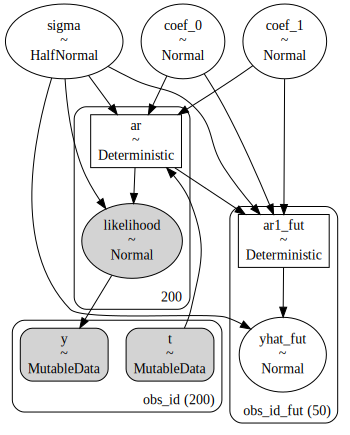

In [10]:
pm.model_to_graphviz(AR)

In [11]:
idata_preds

Inference data with groups:
	> predictions
	> predictions_constant_data

## Inspecting model fit and forecast

We can look at the standard posterior predictive fits but since our data is timeseries data we have to also look how draws from the posterior predictive distribution vary over time.

In [12]:
def plot_fits(idata_ar, idata_preds):
    palette = "plasma"
    cmap = plt.get_cmap(palette)
    percs = np.linspace(51, 99, 100)
    colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))

    fig, axs = plt.subplots(1, 3, sharex=False, figsize=(20, 6))
    axs = axs.flatten()
    for i, p in enumerate(percs[::-1]):
        upper = np.percentile(
            az.extract_dataset(idata_ar, group="prior_predictive", num_samples=100)["likelihood"],
            p,
            axis=1,
        )
        lower = np.percentile(
            az.extract_dataset(idata_ar, group="prior_predictive", num_samples=100)["likelihood"],
            100 - p,
            axis=1,
        )
        color_val = colors[i]
        axs[0].fill_between(
            x=idata_ar["constant_data"]["t"],
            y1=upper.flatten(),
            y2=lower.flatten(),
            color=cmap(color_val),
            alpha=0.1,
        )

    axs[0].plot(
        az.extract_dataset(idata_ar, group="prior_predictive", num_samples=100)["likelihood"].mean(
            axis=1
        ),
        color="cyan",
        label="Mean Prediction",
    )

    axs[0].scatter(x=idata_ar["constant_data"]["t"], y=idata_ar["constant_data"]["y"], color="k")
    axs[0].set_title("Prior Predictive Fit", fontsize=20)

    for i, p in enumerate(percs[::-1]):
        upper = np.percentile(
            az.extract_dataset(idata_preds, group="predictions", num_samples=100)["likelihood"],
            p,
            axis=1,
        )
        lower = np.percentile(
            az.extract_dataset(idata_preds, group="predictions", num_samples=100)["likelihood"],
            100 - p,
            axis=1,
        )
        color_val = colors[i]
        axs[2].fill_between(
            x=idata_preds["predictions_constant_data"]["t"],
            y1=upper.flatten(),
            y2=lower.flatten(),
            color=cmap(color_val),
            alpha=0.1,
        )

        upper = np.percentile(
            az.extract_dataset(idata_preds, group="predictions", num_samples=100)["yhat_fut"],
            p,
            axis=1,
        )
        lower = np.percentile(
            az.extract_dataset(idata_preds, group="predictions", num_samples=100)["yhat_fut"],
            100 - p,
            axis=1,
        )
        color_val = colors[i]
        axs[2].fill_between(
            x=np.linspace(200, 250, 50),
            y1=upper.flatten(),
            y2=lower.flatten(),
            color=cmap(color_val),
            alpha=0.1,
        )

    axs[2].plot(
        az.extract_dataset(idata_preds, group="predictions", num_samples=100)["likelihood"].mean(
            axis=1
        ),
        color="cyan",
    )
    idata_preds.predictions.yhat_fut.mean(["chain", "draw"]).plot(ax=axs[2], color="cyan")
    axs[2].scatter(x=idata_ar["constant_data"]["t"], y=idata_ar["constant_data"]["y"], color="k")
    axs[2].set_title("Posterior Predictions Plotted", fontsize=20)
    axs[2].axvline(np.max(idata_ar["constant_data"]["t"]), color="black")
    az.plot_ppc(idata_ar, ax=axs[1])


plot_fits(idata_ar, idata_preds)

/Users/nathanielforde/opt/miniconda3/envs/pymc_ar_ex/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


Here we can see that although the model converged and ends up with a reasonable fit to the existing the data, and a **plausible  projection** for future values. However, we have set the prior specification very poorly in allowing an absurdly broad range of values due to the kind of compoudning logic of the auto-regressive function. For this reason it's very important to be able to inspect and tailor your model with prior predictive checks. 

## Complicating the Picture

Let's add a trend to our data.

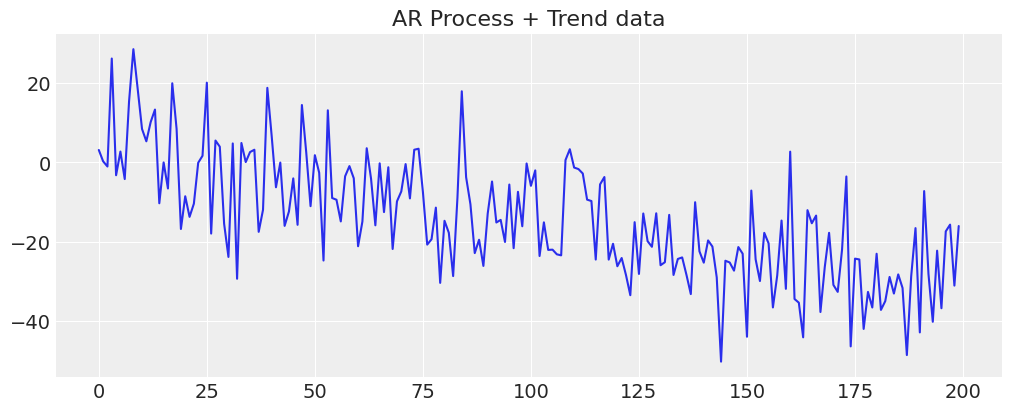

In [13]:
y_t = -0.3 + np.arange(200) * -0.2 + np.random.normal(0, 10, 200)
y_t = y_t + ar1_data

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(y_t)
ax.set_title("AR Process + Trend data");

### Wrapping our model into a function

In [14]:
def make_latent_AR_model(ar_data, priors, prediction_steps=250, full_sample=True, samples=2000):
    with pm.Model() as AR:
        pass

    t_data = list(range(len(ar_data)))
    AR.add_coord("obs_id", t_data, mutable=True)

    with AR:
        ## Data containers to enable prediction
        t = pm.MutableData("t", t_data, dims="obs_id")
        y = pm.MutableData("y", ar_data, dims="obs_id")
        # The first coefficient will be the intercept term
        coefs_0 = pm.Normal("coef_0", priors["coef_0"]["mu"], priors["coef_0"]["sigma"])
        coef_1 = pm.Normal("coef_1", priors["coef_1"]["mu"], priors["coef_1"]["sigma"])
        sigma = pm.HalfNormal("sigma", priors["sigma"])
        # We need one init variable for each lag, hence size is variable too
        init = pm.Normal.dist(
            priors["init"]["mu"], priors["init"]["sigma"], size=priors["init"]["size"]
        )
        # Steps of the AR model minus the lags required given specification
        ar1 = pm.AR(
            "ar",
            at.tensor.as_tensor_variable([coefs_0, coef_1]),
            sigma=sigma,
            init_dist=init,
            constant=True,
            steps=t.shape[0] - (priors["coef_0"]["size"] - 1),
        )

        # The Likelihood
        outcome = pm.Normal("likelihood", mu=ar1, sigma=sigma, observed=y)
        ## Sampling
        idata_ar = pm.sample_prior_predictive()
        if full_sample:
            idata_ar.extend(pm.sample(samples, random_seed=100, target_accept=0.95))
            idata_ar.extend(pm.sample_posterior_predictive(idata_ar))
        else:
            return idata_ar

    n = prediction_steps - ar_data.shape[0]

    with AR:
        AR.add_coords({"obs_id_fut": range(ar1_data.shape[0], 250, 1)})
        # condition on the learned values of the AR process
        # initialise the future AR process precisely at the last observed value in the AR process
        # using the special feature of the dirac delta distribution to be 0 probability everywhere else.
        ar1_fut = pm.AR(
            "ar1_fut",
            init_dist=pm.DiracDelta.dist(ar1[..., -1] + coefs_0),
            rho=at.tensor.as_tensor_variable([coefs_0, coef_1]),
            sigma=sigma,
            constant=True,
            dims="obs_id_fut",
        )
        yhat_fut = pm.Normal("yhat_fut", mu=ar1_fut, sigma=sigma, dims="obs_id_fut")
        # use the updated values and predict outcomes and probabilities:
        idata_preds = pm.sample_posterior_predictive(
            idata_ar, var_names=["likelihood", "yhat_fut"], predictions=True, random_seed=100
        )

    return idata_ar, idata_preds, AR

Next we'll cycle through a number of prior specifications to show how that impacts the prior predictive distribution i.e. the implied distribution of our outcome if we were to forward sample from the model specified by our priors.

In [15]:
priors_0 = {
    "coef_0": {"mu": -4, "sigma": 0.1, "size": 2},
    "coef_1": {"mu": 0.2, "sigma": 0.03, "size": 2},
    "sigma": 8,
    "init": {"mu": 9, "sigma": 0.1, "size": 1},
}

priors_1 = {
    "coef_0": {"mu": -2, "sigma": 0.1, "size": 2},
    "coef_1": {"mu": 0.2, "sigma": 0.03, "size": 2},
    "sigma": 12,
    "init": {"mu": 8, "sigma": 0.1, "size": 1},
}

priors_2 = {
    "coef_0": {"mu": 0, "sigma": 0.1, "size": 2},
    "coef_1": {"mu": 0.2, "sigma": 0.03, "size": 2},
    "sigma": 15,
    "init": {"mu": 8, "sigma": 0.1, "size": 1},
}

models = {}
for i, p in enumerate([priors_0, priors_1, priors_2]):
    models[i] = {}
    idata = make_latent_AR_model(y_t, p, full_sample=False)
    models[i]["idata"] = idata

Sampling: [ar, coef_0, coef_1, likelihood, sigma]
Sampling: [ar, coef_0, coef_1, likelihood, sigma]
Sampling: [ar, coef_0, coef_1, likelihood, sigma]


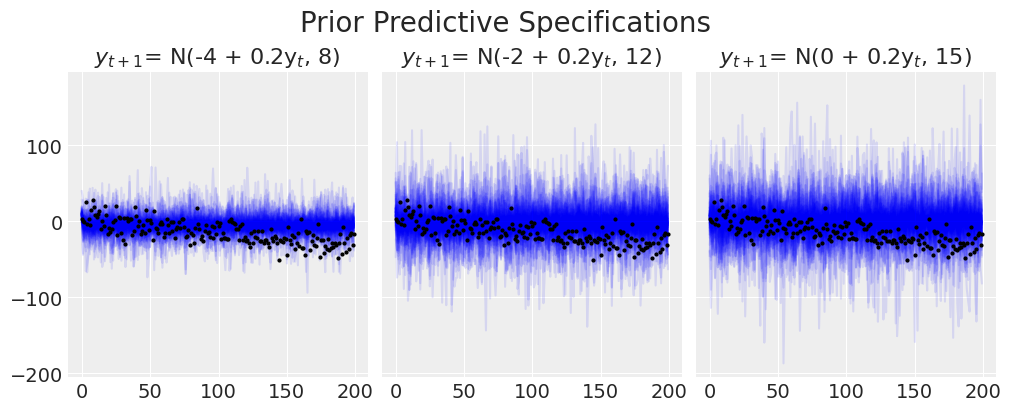

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4), sharey=True)
axs = axs.flatten()
for i, p in zip(range(3), [priors_0, priors_1, priors_2]):
    axs[i].plot(
        az.extract_dataset(models[i]["idata"], group="prior_predictive", num_samples=100)[
            "likelihood"
        ],
        color="blue",
        alpha=0.1,
    )
    axs[i].plot(y_t, "o", color="black", markersize=2)
    axs[i].set_title(
        "$y_{t+1}$" + f'= N({p["coef_0"]["mu"]} + {p["coef_1"]["mu"]}y$_t$, {p["sigma"]})'
    )
plt.suptitle("Prior Predictive Specifications", fontsize=20);

We can see the manner in which the model struggles to capture the trend line. Increasing the variablity of the model will never capture the directional pattern we know to be in the data.

In [17]:
priors_0 = {
    "coef_0": {"mu": -4, "sigma": 0.5, "size": 2},
    "coef_1": {"mu": 0.2, "sigma": 0.03, "size": 2},
    "sigma": 8,
    "init": {"mu": -4, "sigma": 0.1, "size": 1},
}

idata_no_trend, preds_no_trend, model = make_latent_AR_model(y_t, priors_0)

Sampling: [ar, coef_0, coef_1, likelihood, sigma]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [coef_0, coef_1, sigma, ar]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 43 seconds.
Sampling: [likelihood]


Sampling: [ar1_fut, likelihood, yhat_fut]


/Users/nathanielforde/opt/miniconda3/envs/pymc_ar_ex/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


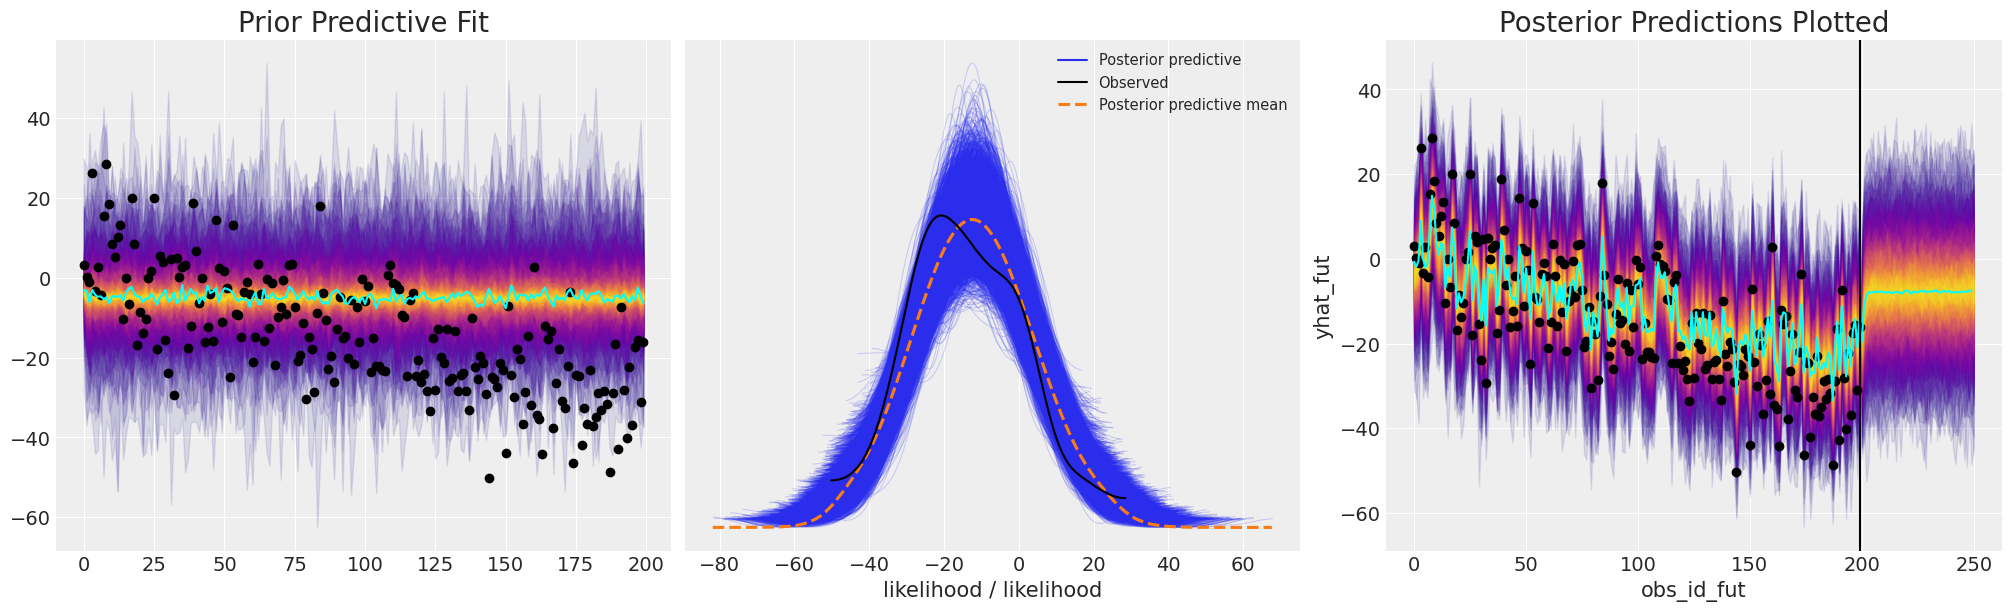

In [18]:
plot_fits(idata_no_trend, preds_no_trend)

Forecasting with this model is somewhat hopeless because, while the model fit adjusts well with observed data, but it completely fails to capture the structural trend in the data. So without some structural constraint when we seek to make predictions with this simple AR model, it reverts to the mean level forecast very quickly.

### Specifying a Trend Model

We will define a model to account for the trend in our data and combine this trend in a additive model with the autoregressive components. Again the model is much as before, but now we add additional latent features. These are to be combined in a simple additive combination but we can be more creative here if it would suit our model.

In [19]:
def make_latent_AR_trend_model(
    ar_data, priors, prediction_steps=250, full_sample=True, samples=2000
):
    with pm.Model() as AR:
        pass

    t_data = list(range(len(ar_data)))
    AR.add_coord("obs_id", t_data, mutable=True)

    with AR:
        ## Data containers to enable prediction
        t = pm.MutableData("t", t_data, dims="obs_id")
        y = pm.MutableData("y", ar_data, dims="obs_id")
        # The first coefficient will be the intercept term
        coef_0 = pm.Normal("coef_0", priors["coef_0"]["mu"], priors["coef_0"]["sigma"])
        coef_1 = pm.Normal("coef_1", priors["coef_1"]["mu"], priors["coef_1"]["sigma"])
        sigma = pm.HalfNormal("sigma", priors["sigma"])
        # We need one init variable for each lag, hence size is variable too
        init = pm.Normal.dist(
            priors["init"]["mu"], priors["init"]["sigma"], size=priors["init"]["size"]
        )
        # Steps of the AR model minus the lags required given specification
        ar1 = pm.AR(
            "ar",
            at.tensor.as_tensor_variable([coef_0, coef_1]),
            sigma=sigma,
            init_dist=init,
            constant=True,
            steps=t.shape[0] - (priors["coef_0"]["size"] - 1),
        )

        ## Priors for the linear trend component
        alpha = pm.Normal("alpha", priors["alpha"]["mu"], priors["alpha"]["sigma"])
        beta = pm.Normal("beta", priors["beta"]["mu"], priors["beta"]["sigma"])
        trend = pm.Deterministic("trend", alpha + beta * t, dims="obs_id")

        mu = ar1 + trend

        # The Likelihood
        outcome = pm.Normal("likelihood", mu=mu, sigma=sigma, observed=y)
        ## Sampling
        idata_ar = pm.sample_prior_predictive()
        if full_sample:
            idata_ar.extend(pm.sample(samples, random_seed=100, target_accept=0.95))
            idata_ar.extend(pm.sample_posterior_predictive(idata_ar))
        else:
            return idata_ar

    n = prediction_steps - ar_data.shape[0]

    with AR:
        AR.add_coords({"obs_id_fut": range(ar1_data.shape[0], prediction_steps, 1)})
        t_fut = pm.MutableData("t_fut", list(range(ar1_data.shape[0], prediction_steps, 1)))
        # condition on the learned values of the AR process
        # initialise the future AR process precisely at the last observed value in the AR process
        # using the special feature of the dirac delta distribution to be 0 probability everywhere else.
        ar1_fut = pm.AR(
            "ar1_fut",
            init_dist=pm.DiracDelta.dist(ar1[..., -1]),
            rho=at.tensor.as_tensor_variable([coef_0, coef_1]),
            sigma=sigma,
            constant=True,
            dims="obs_id_fut",
        )
        trend = pm.Deterministic("trend_fut", alpha + beta * t_fut)
        mu = ar1_fut + trend

        yhat_fut = pm.Normal("yhat_fut", mu=mu, sigma=sigma, dims="obs_id_fut")
        # use the updated values and predict outcomes and probabilities:
        idata_preds = pm.sample_posterior_predictive(
            idata_ar, var_names=["likelihood", "yhat_fut"], predictions=True, random_seed=100
        )

    return idata_ar, idata_preds, AR

We will fit this model by specifying priors on the negative trend and the range of the standard deviation to respect the direction of the data drift.

In [20]:
priors_0 = {
    "coef_0": {"mu": 0.2, "sigma": 0.5, "size": 2},
    "coef_1": {"mu": 0.2, "sigma": 0.03, "size": 2},
    "alpha": {"mu": -4, "sigma": 0.1},
    "beta": {"mu": -0.5, "sigma": 0.1},
    "sigma": 8,
    "init": {"mu": -4, "sigma": 0.1, "size": 1},
}


idata_trend, preds_trend, model = make_latent_AR_trend_model(y_t, priors_0, full_sample=True)

Sampling: [alpha, ar, beta, coef_0, coef_1, likelihood, sigma]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [coef_0, coef_1, sigma, ar, alpha, beta]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 48 seconds.
Sampling: [likelihood]


Sampling: [ar1_fut, likelihood, yhat_fut]


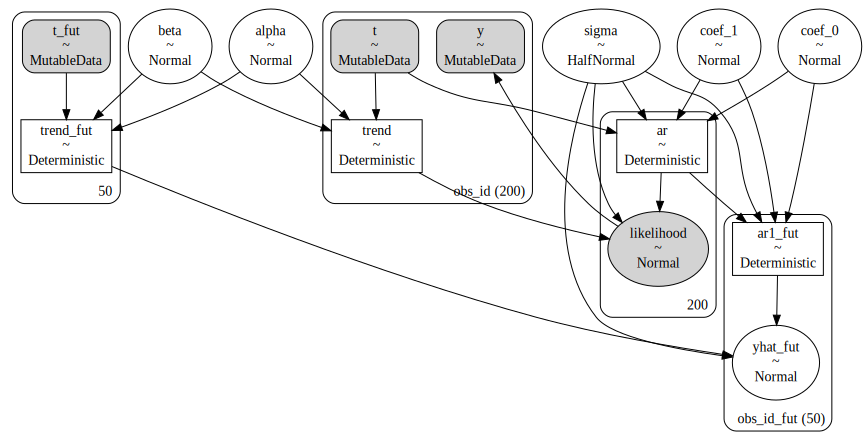

In [21]:
pm.model_to_graphviz(model)

We can see the structure more clearly with the plate notation, and this additional structure has helped to appropriately fit the directional trend of the timeseries data.

/Users/nathanielforde/opt/miniconda3/envs/pymc_ar_ex/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


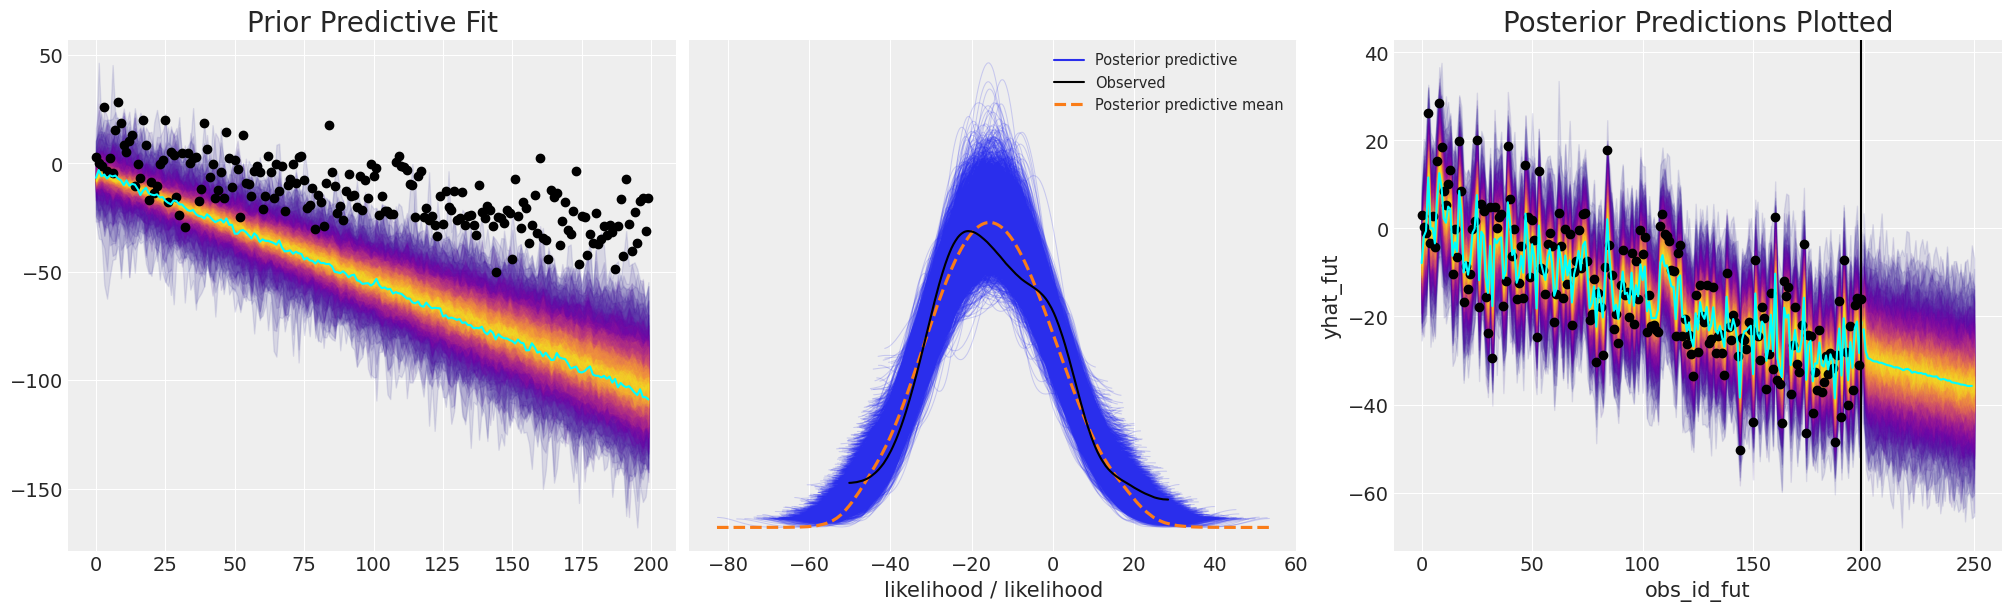

In [22]:
plot_fits(idata_trend, preds_trend);

In [23]:
az.summary(idata_trend, var_names=["coef_0", "coef_1", "sigma", "alpha", "beta"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
coef_0  0.936  0.480   0.054    1.854      0.010    0.007    2355.0    4416.0   
coef_1  0.205  0.030   0.150    0.261      0.000    0.000    8093.0    6056.0   
sigma   8.011  0.403   7.276    8.775      0.007    0.005    3651.0    5101.0   
alpha  -3.975  0.101  -4.169   -3.790      0.001    0.001    9811.0    6197.0   
beta   -0.134  0.009  -0.151   -0.116      0.000    0.000    1462.0    2702.0   

        r_hat  
coef_0    1.0  
coef_1    1.0  
sigma     1.0  
alpha     1.0  
beta      1.0

## Complicating the picture further

Next we'll add a seasonal component to our data and see how we can recover this aspect of the data with a bayesian structural timeseries model.

In [24]:
t_data = list(range(200))
n_order = 10
periods = np.array(t_data) / 7

fourier_features = pd.DataFrame(
    {
        f"{func}_order_{order}": getattr(np, func)(2 * np.pi * periods * order)
        for order in range(1, n_order + 1)
        for func in ("sin", "cos")
    }
)

y_t_s = y_t + 20 * fourier_features["sin_order_1"]

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(y_t_s)
ax.set_title("AR + Trend + Seasonality");

The key to fitting this model is to understand that we're now passing in synthetic fourier features to help account for seasonality effects. This works because (roughly speaking) we're trying to fit a complex oscillating phenomena using a weighted combination of sine and cosine waves. So we add these sine waves and consine waves like we would add any other feature variables in a regression model. 

However, since we're using this weighted sum to fit the observed data, the model now expects a linear combination of those synthetic features **also** in the prediction step. As such we need to be able to supply those features even out into the future. This fact remains key for any other type of predictive feature we might want to add e.g. day of the week, holiday flag or any other. If a feature is required to fit the observed data the feature must be available in the prediction step too. 

### Specifying the Trend + Seasonal Model

In [25]:
def make_latent_AR_trend_seasonal_model(
    ar_data, ff, priors, prediction_steps=250, full_sample=True, samples=2000
):
    with pm.Model() as AR:
        pass

    ff = ff.to_numpy().T
    t_data = list(range(len(ar_data)))
    AR.add_coord("obs_id", t_data, mutable=True)
    ## The fourier features must be mutable to allow for addition fourier features to be
    ## passed in the prediction step.
    AR.add_coord("fourier_features", np.arange(len(ff)), mutable=True)

    with AR:
        ## Data containers to enable prediction
        t = pm.MutableData("t", t_data, dims="obs_id")
        y = pm.MutableData("y", ar_data, dims="obs_id")
        # The first coefficient will be the intercept term
        coef_0 = pm.Normal("coef_0", priors["coef_0"]["mu"], priors["coef_0"]["sigma"])
        coef_1 = pm.Normal("coef_1", priors["coef_1"]["mu"], priors["coef_1"]["sigma"])
        sigma = pm.HalfNormal("sigma", priors["sigma"])
        # We need one init variable for each lag, hence size is variable too
        init = pm.Normal.dist(
            priors["init"]["mu"], priors["init"]["sigma"], size=priors["init"]["size"]
        )
        # Steps of the AR model minus the lags required given specification
        ar1 = pm.AR(
            "ar",
            at.tensor.as_tensor_variable([coef_0, coef_1]),
            sigma=sigma,
            init_dist=init,
            constant=True,
            steps=t.shape[0] - (priors["coef_0"]["size"] - 1),
        )

        ## Priors for the linear trend component
        alpha = pm.Normal("alpha", priors["alpha"]["mu"], priors["alpha"]["sigma"])
        beta = pm.Normal("beta", priors["beta"]["mu"], priors["beta"]["sigma"])
        trend = pm.Deterministic("trend", alpha + beta * t, dims="obs_id")

        ## Priors for seasonality
        beta_fourier = pm.Normal(
            "beta_fourier",
            mu=priors["beta_fourier"]["mu"],
            sigma=priors["beta_fourier"]["sigma"],
            dims="fourier_features",
        )
        fourier_terms = pm.MutableData("fourier_terms", ff)
        seasonality = pm.Deterministic(
            "seasonality", pm.math.dot(beta_fourier, fourier_terms), dims="obs_id"
        )

        mu = ar1 + trend + seasonality

        # The Likelihood
        outcome = pm.Normal("likelihood", mu=mu, sigma=sigma, observed=y)
        ## Sampling
        idata_ar = pm.sample_prior_predictive()
        if full_sample:
            idata_ar.extend(pm.sample(samples, random_seed=100, target_accept=0.95))
            idata_ar.extend(pm.sample_posterior_predictive(idata_ar))
        else:
            return idata_ar

    n = prediction_steps - ar_data.shape[0]
    n_order = 10
    periods = np.arange(n) / 7

    fourier_features_new = pd.DataFrame(
        {
            f"{func}_order_{order}": getattr(np, func)(2 * np.pi * periods * order)
            for order in range(1, n_order + 1)
            for func in ("sin", "cos")
        }
    )

    with AR:
        AR.add_coords({"obs_id_fut": range(ar1_data.shape[0], prediction_steps, 1)})
        t_fut = pm.MutableData("t_fut", list(range(ar1_data.shape[0], prediction_steps, 1)))
        ff_fut = pm.MutableData("ff_fut", fourier_features_new.to_numpy().T)
        # condition on the learned values of the AR process
        # initialise the future AR process precisely at the last observed value in the AR process
        # using the special feature of the dirac delta distribution to be 0 probability everywhere else.
        ar1_fut = pm.AR(
            "ar1_fut",
            init_dist=pm.DiracDelta.dist(ar1[..., -1]),
            rho=at.tensor.as_tensor_variable([coef_0, coef_1]),
            sigma=sigma,
            constant=True,
            dims="obs_id_fut",
        )
        trend = pm.Deterministic("trend_fut", alpha + beta * t_fut)
        seasonality = pm.Deterministic("seasonality_fut", pm.math.dot(beta_fourier, ff_fut))
        mu = ar1_fut + trend + seasonality

        yhat_fut = pm.Normal("yhat_fut", mu=mu, sigma=sigma, dims="obs_id_fut")
        # use the updated values and predict outcomes and probabilities:
        idata_preds = pm.sample_posterior_predictive(
            idata_ar, var_names=["likelihood", "yhat_fut"], predictions=True, random_seed=100
        )

    return idata_ar, idata_preds, AR

In [26]:
priors_0 = {
    "coef_0": {"mu": 0.2, "sigma": 0.5, "size": 2},
    "coef_1": {"mu": 0.2, "sigma": 0.03, "size": 2},
    "alpha": {"mu": -4, "sigma": 0.1},
    "beta": {"mu": -0.5, "sigma": 0.1},
    "beta_fourier": {"mu": 0, "sigma": 0.8},
    "sigma": 8,
    "init": {"mu": -4, "sigma": 0.1, "size": 1},
}


idata_t_s, preds_t_s, model = make_latent_AR_trend_seasonal_model(y_t_s, fourier_features, priors_0)

Sampling: [alpha, ar, beta, beta_fourier, coef_0, coef_1, likelihood, sigma]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [coef_0, coef_1, sigma, ar, alpha, beta, beta_fourier]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 61 seconds.
Sampling: [likelihood]


Sampling: [ar1_fut, likelihood, yhat_fut]


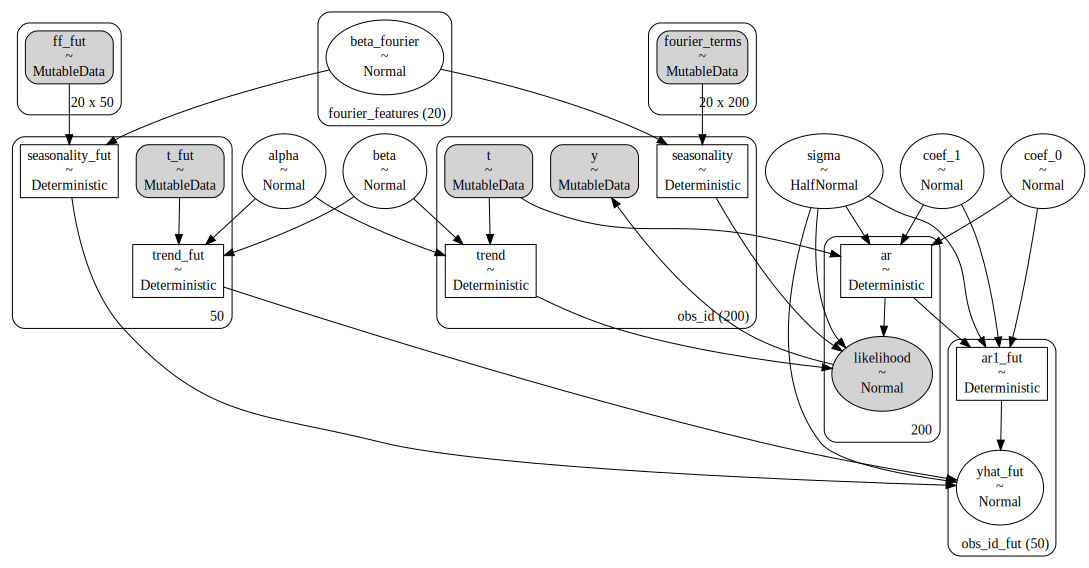

In [27]:
pm.model_to_graphviz(model)

In [28]:
az.summary(idata_t_s, var_names=["alpha", "beta", "coef_0", "coef_1", "beta_fourier"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha            -3.983  0.098  -4.167   -3.801      0.001    0.001   15027.0   
beta             -0.140  0.011  -0.162   -0.120      0.000    0.000    5049.0   
coef_0            0.722  0.483  -0.215    1.594      0.006    0.004    6204.0   
coef_1            0.213  0.029   0.159    0.268      0.000    0.000   12158.0   
beta_fourier[0]   3.255  0.763   1.826    4.713      0.008    0.006    8664.0   
beta_fourier[1]   0.069  0.726  -1.317    1.405      0.006    0.009   13766.0   
beta_fourier[2]   0.116  0.722  -1.196    1.470      0.006    0.008   13502.0   
beta_fourier[3]   0.220  0.718  -1.217    1.526      0.006    0.008   13074.0   
beta_fourier[4]   0.168  0.710  -1.216    1.436      0.006    0.009   14417.0   
beta_fourier[5]  -0.017  0.713  -1.340    1.330      0.006    0.008   13692.0   
beta_fourier[6]  -0.177  0.707  -1.487    1.188      0.006    0.008   13392.0   
beta_fourier[7]  -0.007  0.714  -1.357    1.309      0.006    0.009   14241.0   
beta_fourier[8]  -0.127  0.728  -1.511    1.231      0.006    0.008   14410.0   
beta_fourier[9]   0.223  0.728  -1.106    1.632      0.006    0.008   13374.0   
beta_fourier[10] -3.253  0.754  -4.648   -1.815      0.008    0.006    9300.0   
beta_fourier[11]  0.064  0.746  -1.323    1.444      0.006    0.009   14107.0   
beta_fourier[12] -0.009  0.800  -1.463    1.563      0.007    0.011   14419.0   
beta_fourier[13]  1.134  0.738  -0.254    2.493      0.007    0.006   10391.0   
beta_fourier[14]  3.243  0.759   1.815    4.638      0.008    0.006    9407.0   
beta_fourier[15]  0.060  0.733  -1.303    1.458      0.006    0.008   13260.0   
beta_fourier[16]  0.129  0.722  -1.209    1.522      0.007    0.009   11416.0   
beta_fourier[17]  0.212  0.716  -1.147    1.568      0.006    0.008   13919.0   
beta_fourier[18]  0.155  0.714  -1.151    1.489      0.006    0.008   14165.0   
beta_fourier[19] -0.017  0.719  -1.347    1.330      0.006    0.009   13576.0   

                  ess_tail  r_hat  
alpha               6161.0    1.0  
beta                5695.0    1.0  
coef_0              5896.0    1.0  
coef_1              6451.0    1.0  
beta_fourier[0]     6172.0    1.0  
beta_fourier[1]     5924.0    1.0  
beta_fourier[2]     6031.0    1.0  
beta_fourier[3]     5844.0    1.0  
beta_fourier[4]     6118.0    1.0  
beta_fourier[5]     5917.0    1.0  
beta_fourier[6]     5929.0    1.0  
beta_fourier[7]     6034.0    1.0  
beta_fourier[8]     6128.0    1.0  
beta_fourier[9]     6388.0    1.0  
beta_fourier[10]    5584.0    1.0  
beta_fourier[11]    6274.0    1.0  
beta_fourier[12]    5494.0    1.0  
beta_fourier[13]    6539.0    1.0  
beta_fourier[14]    5783.0    1.0  
beta_fourier[15]    6216.0    1.0  
beta_fourier[16]    5331.0    1.0  
beta_fourier[17]    6105.0    1.0  
beta_fourier[18]    6258.0    1.0  
beta_fourier[19]    5875.0    1.0

/Users/nathanielforde/opt/miniconda3/envs/pymc_ar_ex/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


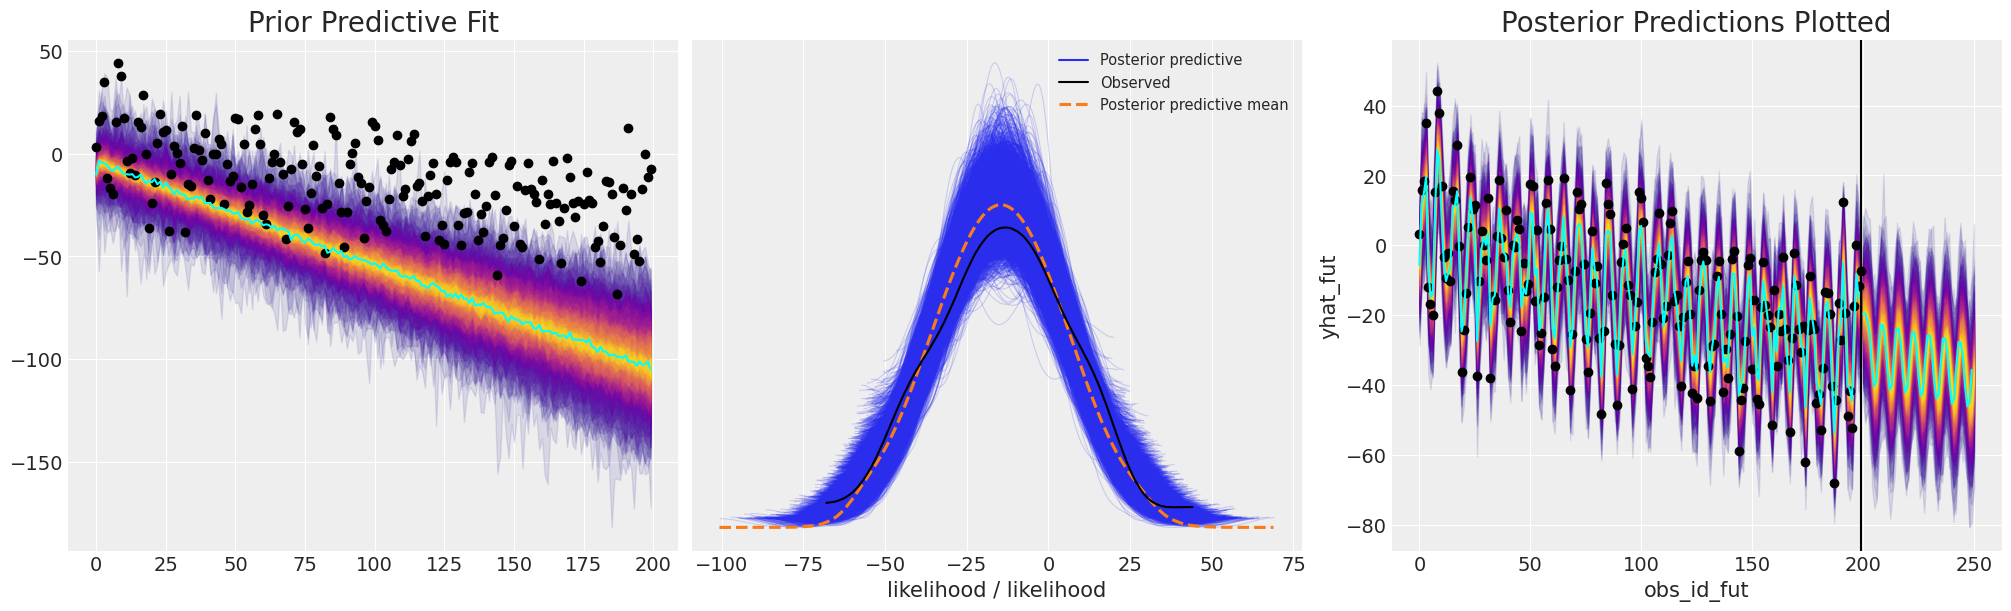

In [29]:
plot_fits(idata_t_s, preds_t_s)

We can see here how the the model fit again recovers the broad structure and trend of the data, but in addition we have captured the oscillation of the seasonal effect and projected that into the future.

# Closing Remarks

The strength of Bayesian model is largely the flexibility it offers for each modelling task. Hopefully this notebook gives a flavour of the variety of combinations worth considering when building a model to suit your use-case. We've seen how the Bayesian structural timeseries approach to forecasting can reveal the structure underlying our data, and be used to project that structure forward in time. We've seen how to encode different assumptions in the data generating model and calibrate our models against the observed data with posterior predictive checks. 

Notably in the case of Auto-regressive modelling we've explicitly relied on the learned posterior distribution of the structural components. In this aspect we think the above is a kind of pure (neatly contained) example of Bayesian learning.

## Authors

Adapted from Nathaniel Forde's [Examined Algorithms Blog](https://nathanielf.github.io/post/bayesian_structural_timeseries/) by Nathaniel Forde in Oct 2022.

## Watermark

In [30]:
%load_ext watermark
%watermark -n -u -v -iv -w -p aesara,aeppl,xarray

Last updated: Sat Oct 22 2022

Python implementation: CPython
Python version       : 3.9.0
IPython version      : 8.4.0

aesara: 2.8.7
aeppl : 0.0.38
xarray: 2022.10.0

numpy     : 1.23.4
sys       : 3.9.0 (default, Nov 15 2020, 06:25:35) 
[Clang 10.0.0 ]
aesara    : 2.8.7
arviz     : 0.12.1
pymc      : 4.2.2
pandas    : 1.5.1
matplotlib: 3.6.1

Watermark: 2.3.1



:::{include} ../page_footer.md
:::